In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas import datetime
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [3]:
zillow = pd.read_csv('../Data_sets/zillow-carlifornia .csv', 
                     index_col="Date", parse_dates=["Date"])
zillow.columns = ["Sold", "Mortgage", "Unemployment", "Rental"]
zillow.head()

,Sold,Mortgage,Unemployment,Rental
Date,,,,
2004-01-31,326752.55,5.02,7.9,NaN
2004-02-29,329501.50,4.94,7.8,NaN
2004-03-31,340125.45,4.74,7.8,NaN
2004-04-30,355329.50,5.16,7.5,NaN
2004-05-31,367818.15,5.64,7.3,NaN


In [4]:
series = zillow.loc[~zillow.Sold.isnull(), "Sold"]
X = series.values
series

Date
2004-01-31    326752.55
2004-02-29    329501.50
2004-03-31    340125.45
2004-04-30    355329.50
2004-05-31    367818.15
                ...    
2015-08-31    426650.00
2015-09-30    421750.00
2015-10-31    417400.00
2015-11-30    420450.00
2015-12-31    421000.00
Name: Sold, Length: 144, dtype: float64

In [25]:
train_size = int(len(X) * 0.80)
train, test = series[:train_size], series[train_size:]

In [13]:
# SARIMAX
exog = zillow.loc[~zillow.Sold.isnull(), ["Unemployment"]]
exog_train = exog.iloc[:train_size]
exog_test = exog.iloc[train_size:]

In [14]:
#auto select orders
model = pm.auto_arima(train, exogenous=exog_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, 
                           start_P=0, seasonal=True,
                           d=1, D=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.summary())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2362.736, BIC=2376.417, Fit time=0.084 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2362.689, BIC=2370.897, Fit time=0.007 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2384.163, BIC=2395.108, Fit time=0.017 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2372.443, BIC=2383.388, Fit time=0.021 seconds
Total fit time: 0.133 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1178.344
Date:                Tue, 10 Dec 2019   AIC                           2362.689
Time:                        20:35:29   BIC                           2370.897
Sample:                             0   HQIC                          2366.020
                                - 115                               

In [15]:
modelx = SARIMAX(train, order=(1,1,3), exog=exog_train)
fitx = modelx.fit()
print(fitx.summary())

                           Statespace Model Results                           
Dep. Variable:                   Sold   No. Observations:                  115
Model:               SARIMAX(1, 1, 3)   Log Likelihood               -1173.252
Date:                Tue, 10 Dec 2019   AIC                           2358.503
Time:                        20:35:38   BIC                           2374.920
Sample:                    01-31-2004   HQIC                          2365.166
                         - 07-31-2013                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Unemployment -1981.9342    673.124     -2.944      0.003   -3301.233    -662.635
ar.L1            0.9169      0.052     17.623      0.000       0.815       1.019
ma.L1           -0.8882      0.053    -16.88

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


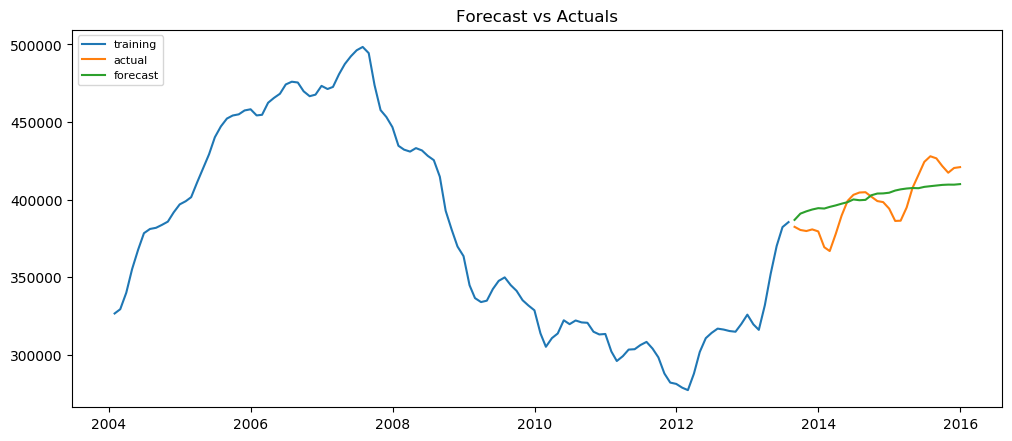

In [16]:
fc = fitx.predict(start='2013-08-31', end='2015-12-31', exog=exog_test)
fc_series = pd.Series(fc)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [17]:
mse = ((fc_series - test) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

13287.87


In [18]:
#VAR
series = zillow.loc[~zillow.Sold.isnull(), ["Sold", "Unemployment"]]
train = series[:int(0.8*(len(series)))]
test = series[int(0.8*(len(series))):]
train.head()

,Sold,Unemployment
Date,,
2004-01-31,326752.55,7.9
2004-02-29,329501.50,7.8
2004-03-31,340125.45,7.8
2004-04-30,355329.50,7.5
2004-05-31,367818.15,7.3


In [19]:
model = VAR(endog=train)
model_fit = model.fit(2)
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Dec, 2019
Time:                     20:36:05
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    16.1659
Nobs:                     113.000    HQIC:                   16.0225
Log likelihood:          -1210.42    FPE:                8.24119e+06
AIC:                      15.9245    Det(Omega_mle):     7.55758e+06
--------------------------------------------------------------------
Results for equation Sold
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const               -9722.775635     10029.597682           -0.969           0.332
L1.Sold                 1.666418         0.070202           23.737           0.000
L1.Unemployment       597.647046      1042.589206    

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [20]:
fc = model_fit.forecast(model_fit.y, steps=len(test))
cols = series.columns
pred = pd.DataFrame(index=test.index,columns=[cols])
for j in range(0,2):
    for i in range(0, len(fc)):
        pred.iloc[i][j] = fc[i][j]

/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


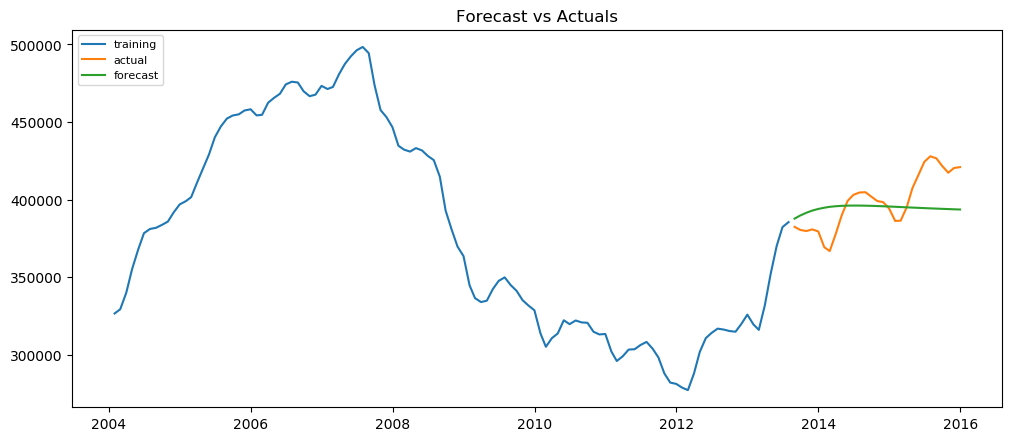

In [21]:
fc_series = pd.Series(fc[:, 0])
fc_series.index = test.Sold.index
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.Sold, label='training')
plt.plot(test.Sold, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [22]:
fc_series = pd.Series(fc[:, 0])
mse = ((fc_series.values - test.Sold.values) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

17890.82


In [32]:
# ES
series = zillow.loc[~zillow.Sold.isnull(), "Sold"]
train_size = int(len(X) * 0.8)
train, test = series[:train_size], series[train_size:]
model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12,damped=True)
model2 = ExponentialSmoothing(train, trend="add", seasonal="mul", seasonal_periods=12, damped=True)
fit = model.fit()
pred = fit.forecast(len(test))
fit2 = model2.fit()
pred2 = fit2.forecast(len(test))

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


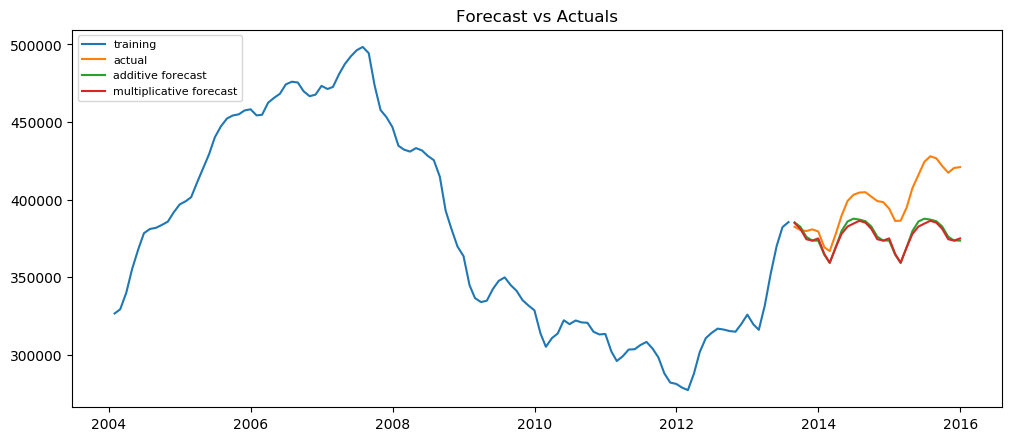

In [33]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred, label='additive forecast')
plt.plot(pred2, label='multiplicative forecast')
plt.title('Forecast vs Actuals')
# plt.plot(pred3, label='forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [34]:
mse = ((pred.values - test.values) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

25716.92
